# Logistic Regression

Using **Income Prediction** dataset and applying **Data Preprossor** to process data.

**Processing Steps**

- Loading data
- Converting target column from string to numbers
- Building a pipeline for data processing
- Applying the pipeline to the dataframe
- Building a Logistic Regression Model
- Exploring trained model performance
- Exploring model performance using Confusion Matrix
- Persisting the pipeline and model


## Data Review

The Adult dataset is publicly available at the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Adult).
This data derives from census data, and consists of information about individuals and their annual income.
We will use this information to predict if an individual earns **<=50K or >50k** a year.
The dataset is rather clean, and consists of both numeric and categorical variables.

Attribute Information:

- age: continuous
- workclass: Private,Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked
- fnlwgt: continuous
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc...
- education-num: continuous
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent...
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners...
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black
- sex: Female, Male
- capital-gain: continuous
- capital-loss: continuous
- hours-per-week: continuous
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany...

Target/Label: - <=50K, >50K

In [1]:
# setting available options to True
%config IPCompleter.greedy = True

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.style.use('seaborn-whitegrid')    # grids in the plots
warnings.filterwarnings('ignore')

**Reading Data**

In [3]:
# reading data
df = pd.read_csv('../data/agent.csv')

In [4]:
# checking first rows
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# checking shape
df.shape

(30933, 15)

**Converting the income from string to number using LabelEncoder**

In [6]:
# using LabelIEncoder to convert income column data type
labelencoder = LabelEncoder()
df['income'] = labelencoder.fit_transform(df.income)

In [7]:
# checking last few rows
df['income'].tail()

30928    0
30929    1
30930    0
30931    0
30932    1
Name: income, dtype: int64

**Handling Categorical columns** - Building a pipeline to process data. 
- For numerical columns - replace missing values with median and apply standard scaler to standardize columns.
- For the categorical column - fill any missing value with constant and perform One Hot Encoding (similar to pd_dummies).


In [8]:
# defining the pipeline stages for numeric and categorical columns
numericPipe = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                              ('scaler', StandardScaler())])
stringPipe = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', 
                                                       fill_value='missing')),
                             ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [9]:
# creating a list of numeric and categorical columns
numericCols = df.select_dtypes(include=['int64', 'float64']).columns
stringCols = df.select_dtypes(include=['object']).columns

In [10]:
# checking numeric cols
numericCols

Index(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'income'],
      dtype='object')

In [11]:
# checking cat. cols
stringCols

Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country'],
      dtype='object')

The **income column (int32)** is not in any list.


**Processing the pipeline**

- Using *Column Transformer* to define the numeric and categorical transformers defined above.
- Fitting and transforming the dataframe.

This estimator allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms or transformations into a single transformer.

In [12]:
# defining column transformer
preprocessor = ColumnTransformer(transformers=[('num', numericPipe, numericCols),
                                               ('cat', stringPipe, stringCols)])

In [13]:
# creating a df 
df1 = preprocessor.fit_transform(df)

In [14]:
# checking df shape
df1.shape

(30933, 109)

In [15]:
# checking df
print(type(df1))

<class 'scipy.sparse.csr.csr_matrix'>


In [16]:
# defininf train and test sets
X = df1
y = df['income'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, 
                                                    random_state = 2345)

In [17]:
# checking train
X_train.shape

(18559, 109)

In [18]:
# checking test
X_test.shape

(12374, 109)

## Modelling
Using Logistic Regression to build model.

In [19]:
# defining and creating model
logReg = LogisticRegression(solver = 'lbfgs', random_state = 2345)
logReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=2345, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

**Exploring Training Performance**

**ROC Curve**
- A visual way to measure the performance of binary classifier ROC (Receiver Operating Characteristic) Curve
- Created by plotting True Positive Rate (TPR or recall) against False Positive Rate (FPR)

**AUC - Area Under the ROC curve**

- AUC is a good measure of performance of the classifier
- If it is near 0.5, the classifier is not much better than random guessing
- Classifier gets better when the curve get close to 1
- Since our value is close to 1, it indicates that classifier is good at minimizing false negatives (not purchased as purchased) and true negative (purchased is classified as purchased).

**Note:** It is only valid for Binary Classification.

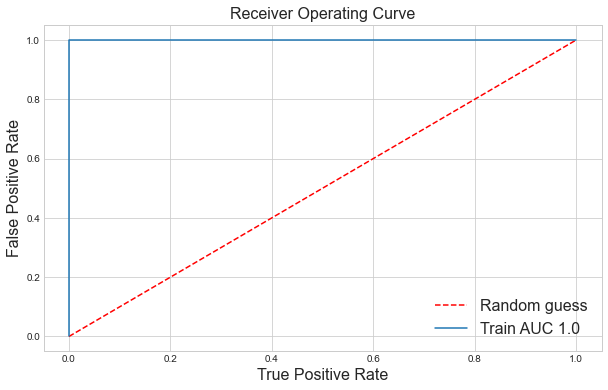

In [20]:
# defining roc auc score
logReg_auc = roc_auc_score(y_test, logReg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logReg.predict_proba(X_test)[:,1])

auc = str(np.round(logReg_auc, 4))
plt.figure(figsize = (10, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess', color = 'red')
plt.plot(fpr, tpr, label = "Train AUC " + auc)
plt.ylabel('False Positive Rate', fontsize = 16)
plt.xlabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Curve', fontsize = 16)
plt.legend(loc = 4, fontsize = 16)
plt.show()

## Make Predictions

In [21]:
# making predictions on the test data and save them
y_pred = logReg.predict(X_test)

In [22]:
# showing score of how good our model performed
logReg.score(X_test, y_test)

1.0

In [23]:
# printing classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9319
           1       1.00      1.00      1.00      3055

   micro avg       1.00      1.00      1.00     12374
   macro avg       1.00      1.00      1.00     12374
weighted avg       1.00      1.00      1.00     12374



## Confusion Matrix

In [24]:
# defining confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[9319,    0],
       [   0, 3055]])

In [25]:
# printing Acurate and Error prediction counts
correct = cm[0, 0] + cm[1, 1]
error = cm[0, 1] + cm[1,0]
total = correct + error
print('Correct predictions: {} of {}'.format(correct, total))
print('Errored predictions: {} of {}'. format(error, total))

Correct predictions: 12374 of 12374
Errored predictions: 0 of 12374


In [26]:
# saving to a df
cseg = ["<= 50K", "> 50K"]
cm_df = pd.DataFrame(cm, index = cseg, columns = cseg)

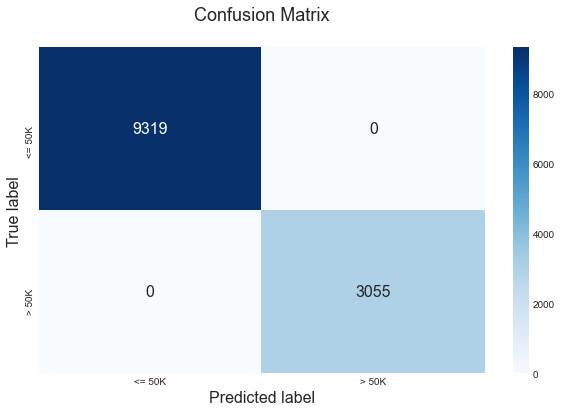

In [27]:
# plotting the confusion matrix
plt.figure(figsize = (10, 6))
sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues, fmt = 'g', annot_kws={"size": 16})
sns.set(font_scale=0.5)
plt.title('Confusion Matrix\n', fontsize = 18)
plt.ylabel('True label', fontsize = 16)
plt.xlabel('Predicted label', fontsize = 16)
plt.show()

**Saving the preprocessor**

In [28]:
from pickle import dump
dump(preprocessor, open('./preprocessor.pkl', 'wb'))

**Saving the model**

In [29]:
from joblib import dump
dump(logReg, './logRegModel.joblib')

['./logRegModel.joblib']